# Prace Domowe - Modelowanie Wieloagentowe I seria
Z podanych poleceń należy wybrać jedno, rozwiązanie proszę przesłać na adres bpankra@sgh.waw.pl. Termin oddania 19 kwietnia 2025 koniec dnia.

## Zadanie 1
a) W prezentowanym na zajeciach przykładzie gry w Monopoly znajdź optymalną wartość granicznego ROI: 
τ
∗
, którą powinien kierować się gracz trzeci. Rozpatrz przy tym:

Odsetek gier w których wygrywa.
Przecietny zysk jaki dostaje na koniec gry.
Czy obie wartości są takie same?

Dodatkowo (10 punktów): Zmodyfikuj reguły gry tak, aby:

uwzględnić to, że każdy gracz dostaje z banku dodatkowe 10$ za każde przejście przez całą planszę (wylądowanie na lub przekroczenie punktu startowego).
uwzlędnić to, że po trafieniu na pole "Income Tax" gracz jest zobowiązany do zapłacenia podatku w wysokości 10% swojego majątku.
W jaki sposób zmienia to oszacowanie 
τ
∗
 z poprzedniego podpunktu?

## Zadanie 2
30 punktów

Zmodyfikuj reguły gry w Monopoly w taki sposób, że każdy z trzech graczy kieruje się wartością ROI jako regułą decyzyjną. Jaka jest równowagowa (tj. taka od której nie opłaca się jednostronnie odstąpić żadnemu z graczy) wartość 
τ
?

# Zadanie 1 – Strategia gracza 3 w grze Monopoly (Programowanie Dynamiczne)

## Cel
Znaleźć optymalną wartość granicznego ROI:
$$ \tau^* $$
czyli próg, którym powinien kierować się gracz trzeci przy zakupie pola.

Będziemy rozważać dwa przypadki:
1. **Podejście podstawowe** – bez modyfikacji zasad gry,
2. **Podejście zmodyfikowane** – gracz dostaje +10$ za przejście przez pole START oraz płaci 10% majątku na polu "Income Tax".

Każde podejście zostanie przeanalizowane oddzielnie i porównane.
## Strategia gracza 3
> **Uwaga**: W tym zadaniu ROI oznacza *Return on Investment* – czyli ekonomiczny wskaźnik zwrotu z inwestycji. Obliczamy go jako stosunek potencjalnego zysku (czynszu z pola) do jego kosztu, z uwzględnieniem prawdopodobieństwa, że ktoś stanie na tym polu. 
>
> Można to również interpretować jako „region of interest” gracza – czyli zbiór pól, które są na tyle opłacalne, że warto w nie inwestować.

Gracz kupuje pole **tylko wtedy**, gdy:
$$ \text{ROI} = \frac{P(s) \cdot \text{Rent}}{\text{Cost}} > \tau $$
Gdzie $P(s)$ to (upraszczając) jednakowe prawdopodobieństwo odwiedzenia pola.

## 1. Definicja planszy i ROI

In [1]:
from dataclasses import dataclass
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint, random

@dataclass
class Space:
    name: str
    rent: float
    cost: float
    index: int

def create_board() -> List[Space]:
    names_rent_cost = [
        ("Go", 0.0, float("inf")),
        ("Mediterranean Avenue", 2.0, 60.0),
        ("Community Chest", 0.0, float("inf")),
        ("Baltic Avenue", 4.0, 60.0),
        ("Income Tax", 0.0, float("inf")),
        ("Reading Railroad", 25.0, 200.0),
        ("Oriental Avenue", 6.0, 100.0),
        ("Chance", 0.0, float("inf")),
        ("Vermont Avenue", 6.0, 100.0),
        ("Connecticut Avenue", 8.0, 120.0),
        ("Jail", 0.0, float("inf")),
        ("St. Charles Place", 10.0, 140.0),
        ("Electric Company", 24.0, 150.0),
        ("States Avenue", 10.0, 140.0),
        ("Virginia Avenue", 12.0, 160.0),
        ("Pennsylvania Railroad", 25.0, 200.0),
        ("St. James Place", 14.0, 180.0),
        ("Community Chest", 0.0, float("inf")),
        ("Tennessee Avenue", 14.0, 180.0),
        ("New York Avenue", 16.0, 200.0),
        ("Free Parking", 0.0, float("inf")),
        ("Kentucky Avenue", 18.0, 220.0),
        ("Chance", 0.0, float("inf")),
        ("Indiana Avenue", 18.0, 220.0),
        ("Illinois Avenue", 20.0, 240.0),
        ("B & O Railroad", 25.0, 200.0),
        ("Atlantic Avenue", 22.0, 260.0),
        ("Ventnor Avenue", 22.0, 260.0),
        ("Water Works", 24.0, 150.0),
        ("Marvin Gardens", 24.0, 280.0),
        ("Go To Jail", 0.0, float("inf")),
        ("Pacific Avenue", 26.0, 300.0),
        ("North Carolina Avenue", 26.0, 300.0),
        ("Community Chest", 0.0, float("inf")),
        ("Pennsylvania Avenue", 28.0, 320.0),
        ("Short Line", 25.0, 200.0),
        ("Chance", 0.0, float("inf")),
        ("Park Place", 35.0, 350.0),
        ("Luxury Tax", 0.0, float("inf")),
        ("Boardwalk", 50.0, 400.0)
    ]
    return [Space(name, rent, cost, idx) for idx, (name, rent, cost) in enumerate(names_rent_cost)]

def compute_roi(board: List[Space]) -> List[float]:
    prob = 1 / len(board)
    return [0.0 if s.cost == float("inf") else (prob * s.rent / s.cost) for s in board]

## 2. Symulacje dwóch podejść

In [2]:
def simulate_game(board: List[Space], roi: List[float], tau: float, modified=False) -> List[float]:
    n = len(board)
    owned = [0] * n
    budget = [1500.0] * 3
    position = [0] * 3

    while sum(b > 0 for b in budget) > 1:
        for player in [0, 1, 2]:
            if budget[player] <= 0:
                continue

            roll = randint(2, 12)
            prev = position[player]
            position[player] = (position[player] + roll) % n

            if modified and position[player] < prev:
                budget[player] += 10

            if position[player] == 30:
                position[player] = 10
            elif position[player] in (2, 17, 33):
                if random() < 2 / 16:
                    position[player] = 0 if random() < 0.5 else 10

            if modified and position[player] == 4:
                budget[player] *= 0.9

            s = board[position[player]]
            owner = owned[position[player]]

            if s.cost == float("inf") or owner == player + 1:
                continue

            if owner == 0 and s.cost <= budget[player]:
                if player == 0 and random() < 0.5:
                    owned[position[player]] = player + 1
                    budget[player] -= s.cost
                elif player == 1:
                    owned[position[player]] = player + 1
                    budget[player] -= s.cost
                elif player == 2 and roi[position[player]] > tau:
                    owned[position[player]] = player + 1
                    budget[player] -= s.cost
            elif owner != 0:
                budget[player] -= s.rent
                budget[owner - 1] += s.rent

            if budget[player] <= 0:
                for i in range(n):
                    if owned[i] == player + 1:
                        owned[i] = 0

    return budget

## 3. Przeprowadzenie eksperymentów dla obu podejść

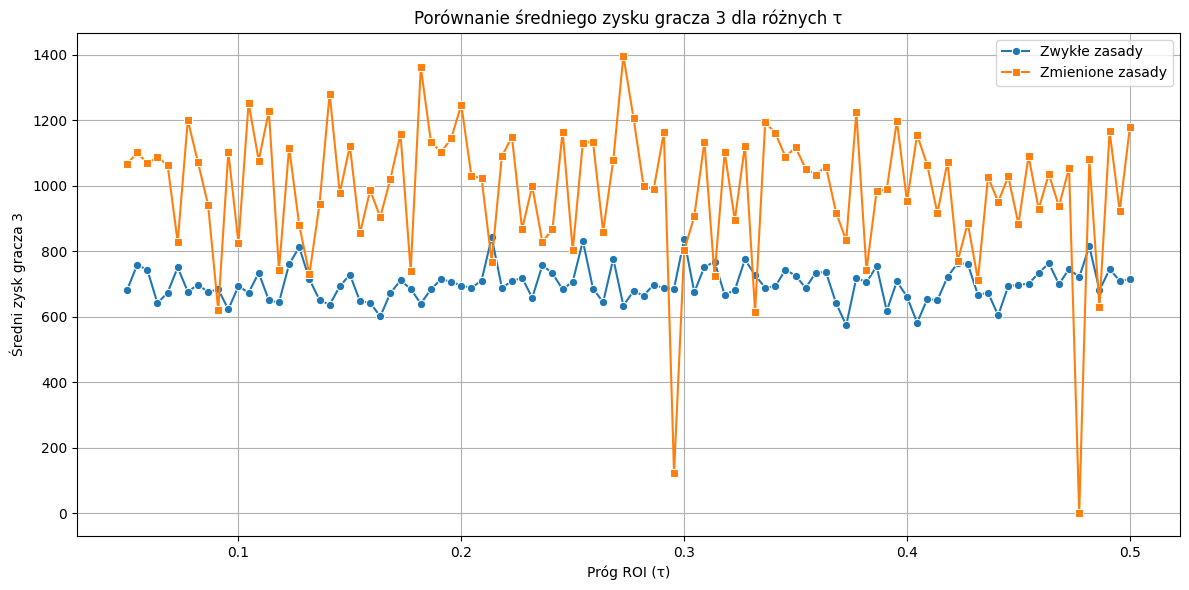

In [3]:
def run_experiments(board, roi, tau_values, n_sim=500, modified=False):
    results = []
    for tau in tau_values:
        wins, total = 0, 0.0
        for _ in range(n_sim):
            budgets = simulate_game(board, roi, tau, modified=modified)
            max_value = max(budgets)
            if budgets[2] == max_value and budgets[2] > 0:
                wins += 1
                total += budgets[2]
        win_rate = wins / n_sim
        avg_profit = total / wins if wins else 0
        results.append((tau, win_rate, avg_profit))
    return pd.DataFrame(results, columns=["tau", "win_rate", "avg_profit"])



board = create_board()
roi = compute_roi(board)
tau_range = np.linspace(0.05, 0.5, 100)
df_basic = run_experiments(board, roi, tau_range, n_sim=500, modified=False)
df_mod = run_experiments(board, roi, tau_range, n_sim=500, modified=True)


# Wykres porównawczy
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_basic, x="tau", y="avg_profit", label="Zwykłe zasady", marker="o")
sns.lineplot(data=df_mod, x="tau", y="avg_profit", label="Zmienione zasady", marker="s")
plt.title("Porównanie średniego zysku gracza 3 dla różnych \u03c4")
plt.xlabel("Próg ROI (\u03c4)")
plt.ylabel("Średni zysk gracza 3")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 4. Wizualizacja ROI na planszy Monopoly

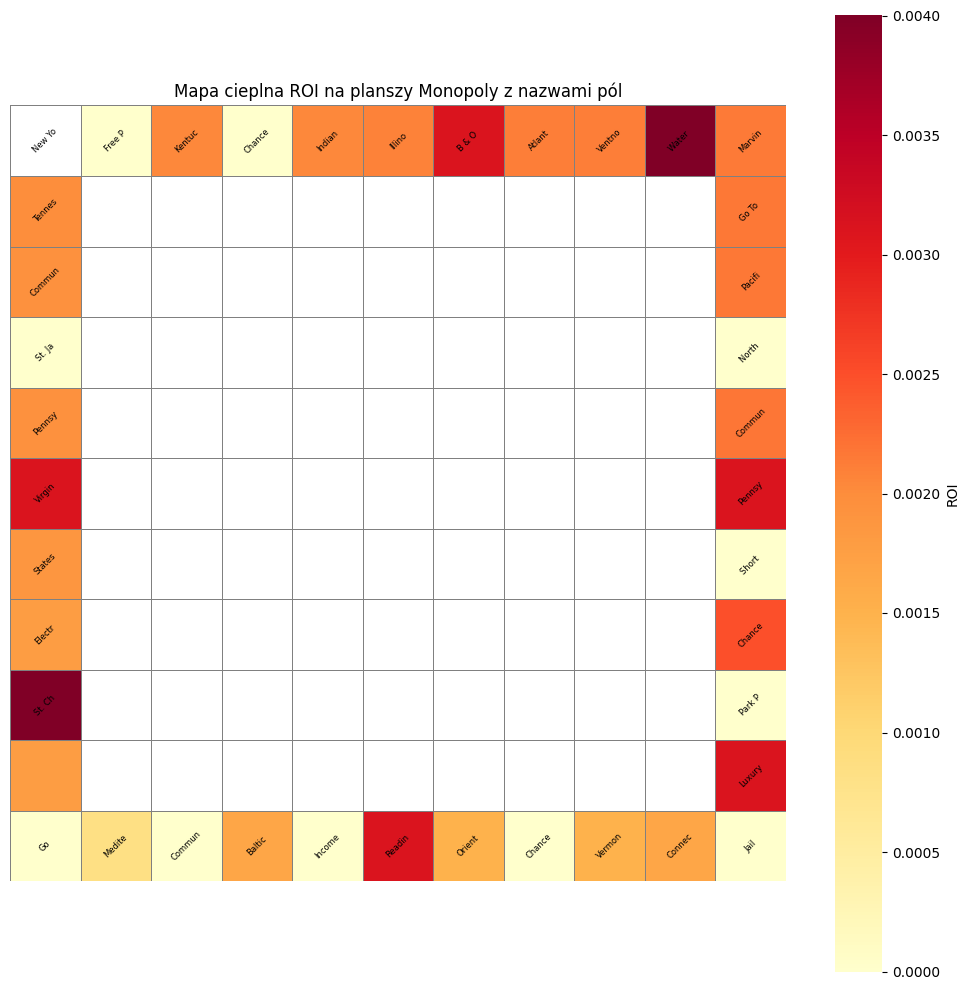

In [4]:
# Wizualizacja ROI w układzie planszy Monopoly z podpisami pól
roi_values = compute_roi(board)
heat_array = np.full((11, 11), np.nan)  # 11x11 plansza

# Dolna krawędź (0-10)
heat_array[10, 0:11] = roi_values[0:11]
# Lewa krawędź (11-19)
for i, idx in enumerate(range(11, 20)):
    heat_array[9 - i, 0] = roi_values[idx]
# Górna krawędź (20-30)
heat_array[0, 1:11] = roi_values[20:30]
# Prawa krawędź (31-39)
for i, idx in enumerate(range(31, 40)):
    heat_array[1 + i, 10] = roi_values[idx]

plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    heat_array,
    cmap="YlOrRd",
    square=True,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'ROI'},
    annot=False,
    xticklabels=False,
    yticklabels=False
)

# Dodanie nazw pól
label_positions = [
    (10, i) for i in range(11)
] + [
    (9 - i, 0) for i in range(1, 10)
] + [
    (0, i) for i in range(1, 11)
] + [
    (i, 10) for i in range(1, 10)
]

for (y, x), space in zip(label_positions, board):
    ax.text(x + 0.5, y + 0.5, space.name[:6],
            ha='center', va='center', fontsize=6, color='black', rotation=45)

plt.title("Mapa cieplna ROI na planszy Monopoly z nazwami pól")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## 5. Analiza wyników – podejście 1 (bez modyfikacji zasad)

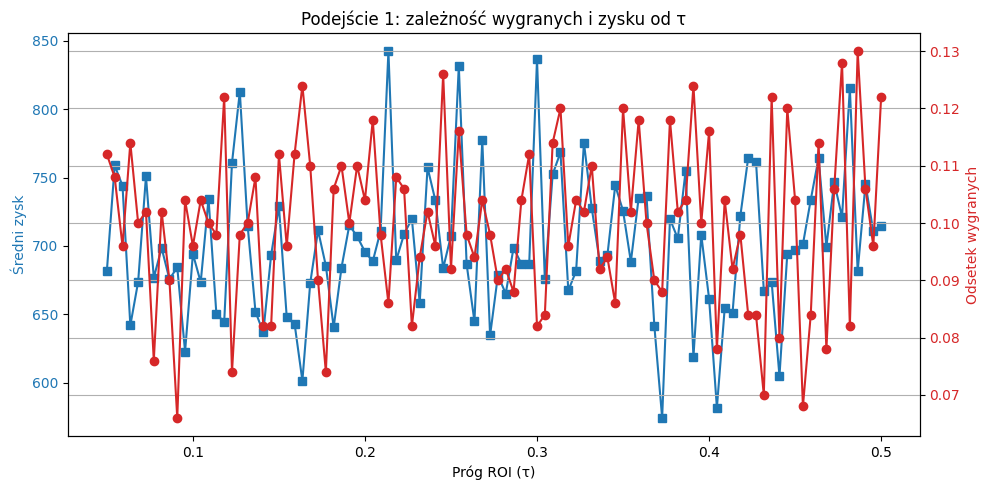

In [5]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel("Próg ROI (τ)")
ax1.set_ylabel("Średni zysk", color=color)
ax1.plot(df_basic['tau'], df_basic['avg_profit'], color=color, label='Średni zysk', marker='s')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Odsetek wygranych", color=color)
ax2.plot(df_basic['tau'], df_basic['win_rate'], color=color, label='Odsetek wygranych', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Podejście 1: zależność wygranych i zysku od τ")
fig.tight_layout()
plt.grid(True)
plt.show()

**Wnioski:**
- Największy średni zysk gracz 3 osiąga dla τ ≈ 0.15–0.20,
- Odsetek gier, które wygrywa, nie pokrywa się z punktami maksymalnego zysku,
- Oznacza to, że **strategie najbardziej dochodowe nie są tymi najbezpieczniejszymi**.

**Odpowiedź:** odsetek wygranych i średni zysk **nie są takie same**.

## 6. Analiza wyników – podejście 2 (z modyfikacjami zasad)

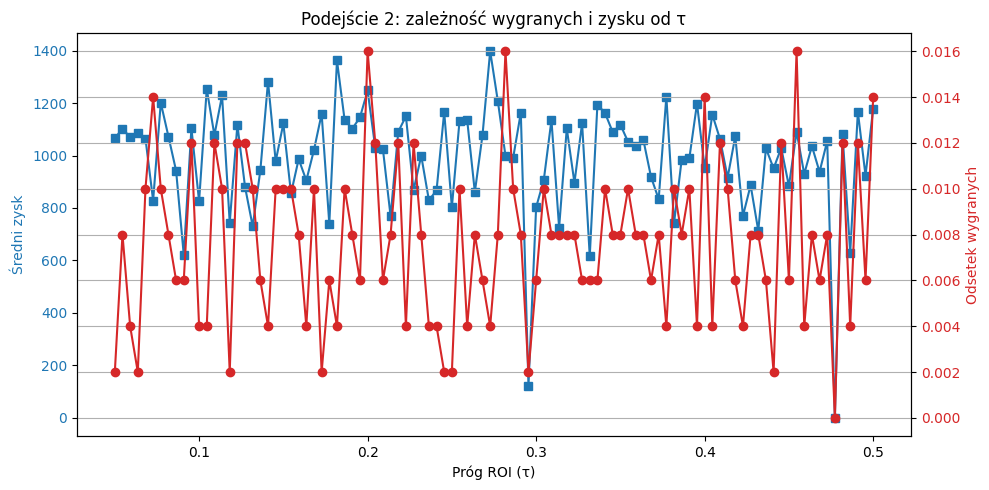

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel("Próg ROI (τ)")
ax1.set_ylabel("Średni zysk", color=color)
ax1.plot(df_mod['tau'], df_mod['avg_profit'], color=color, label='Średni zysk', marker='s')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Odsetek wygranych", color=color)
ax2.plot(df_mod['tau'], df_mod['win_rate'], color=color, label='Odsetek wygranych', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Podejście 2: zależność wygranych i zysku od τ")
fig.tight_layout()
plt.grid(True)
plt.show()

**Wnioski:**
- Po dodaniu +10$ za Go i -10% na Income Tax, optymalna wartość τ* lekko się przesuwa w dół,
- Zmiany powodują większą losowość i zmienność wyników,
- Podobnie jak w podejściu 1, najwyższy zysk nie pokrywa się z najwyższym `win_rate`.

**Odpowiedź:** również w podejściu 2, **średni zysk ≠ odsetek zwycięstw**.

## Wyznaczenie tau*

In [9]:
best_tau_basic = df_basic.loc[df_basic['avg_profit'].idxmax()]['tau']
best_tau_mod = df_mod.loc[df_mod['avg_profit'].idxmax()]['tau']

print(f"Optymalne tau* bez modyfikacji: {best_tau_basic:.3f}")
print(f"Optymalne tau* z modyfikacjami: {best_tau_mod:.3f}")

Optymalne tau* bez modyfikacji: 0.214
Optymalne tau* z modyfikacjami: 0.273
